In [ ]:
NUM_CLIENTS = 10
POINTS_PER_CLIENT = 240
BATCH_SIZE = 40
ROUNDS = 20
EPOCHS = 32
CLIENT_LEARNING_RATE = 0.01
SERVER_LEARNING_RATE = 0.1

# Instalaciones e importaciones

In [ ]:
!pip install --upgrade tensorflow-federated

In [2]:
import collections

import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt

print(f"Tensorflow version: {tf.__version__}")
print(f"TFF version: {tff.__version__}")

Tensorflow version: 2.14.1
TFF version: 0.87.0


# Lectura de datos

In [ ]:
def fn(x):
    return (-x * (x - 6) * x) + (30 * np.sin(3 * x))

In [ ]:
def create_dataset(num_clients=NUM_CLIENTS, points_per_client=100, batch_size=BATCH_SIZE):
    # Generar puntos
    X = np.linspace(-10.0, 10.0, num_clients * points_per_client)
    # Generamos las etiquetas
    y = fn(X)
    # Crear un dataset de tuplas (x, y)
    X_tensor = tf.reshape(tf.convert_to_tensor(X, dtype=tf.float32), [-1, 1])
    y_tensor = tf.reshape(tf.convert_to_tensor(y, dtype=tf.float32), [-1, 1])
    dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    # Mezclamos los puntos
    dataset = dataset.shuffle(num_clients * points_per_client, 0)

    # Dividir el dataset en diferentes clientes
    client_datasets = []
    for i in range(num_clients):
        # Tomamos el subconjunto de datos para cada cliente
        client_data = dataset.skip(i * points_per_client).take(points_per_client)
        # Crear un dataset para cada cliente y agregarlo a la lista
        client_dataset = client_data.batch(batch_size)
        client_datasets.append(client_dataset)
    return client_datasets

train = create_dataset(points_per_client=POINTS_PER_CLIENT)

# Generar modelo de Tensorflow y adaptarlo para Tensorflow Federated

In [4]:
def create_keras_model(weights=None):
    initializer = tf.keras.initializers.GlorotNormal(seed=0)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(5, activation='relu', initializer=initializer),
        tf.keras.layers.Dense(10, activation='relu', initializer=initializer),
        tf.keras.layers.Dense(1, initializer=initializer)
    ])
    if weights is not None:
        model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()]
        )
        weights.assign_weights_to(model)
    return model

In [ ]:
def create_federated_keras_model():
    model = create_keras_model()
    return tff.learning.models.functional_model_from_keras(
        model,
        loss_fn=tf.keras.losses.MeanSquaredError(),
        input_spec=train[0].element_spec,
        metrics_constructor=collections.OrderedDict(
            mae=tf.keras.metrics.MeanAbsoluteError
        )
    )

In [ ]:
model = create_federated_keras_model()

# Fase de inicialización del algoritmo

In [ ]:
@tff.tensorflow.computation
def server_init():
    return tff.learning.models.ModelWeights(*model.initial_weights)

@tff.federated_computation
def initialize_fn():
    return tff.federated_eval(server_init, tff.SERVER)

# Construir el algoritmo de aprendizaje federado

Esta formado por cuatro partes principales

* **Server-to-client broadcast**: paso de los pesos del modelo de la parte del servidor a los clientes
* **Client update**: actualizar el modelo en cada cliente, con sus datos personales.
* **Client-to-server upload**: paso de los pesos de los modelos locales del cliente al servidor para que se realize una media de los pesos de cada uno de los modelos.
* **Server update**: actualización del modelo del servidor mediante la media de los pesos realizada.

## Obtener tipos de los datos

In [ ]:
dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(model.input_spec))
model_weights_type = server_init.type_signature.result

print(f"Dataset type: {dataset_type}")
print(f"Model weights type: {model_weights_type}")

Dataset type: <float32[?,1],float32[?,1]>*
Model weights type: <trainable=<float32[1,5],float32[5],float32[5,10],float32[10],float32[10,1],float32[1]>,non_trainable=<>>


In [ ]:
federated_client_type = tff.FederatedType(dataset_type, tff.CLIENTS)
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)

print(f"Federated client type: {federated_client_type}")
print(f"Federated server type: {federated_server_type}")

Federated client type: {<float32[?,1],float32[?,1]>*}@CLIENTS
Federated server type: <trainable=<float32[1,5],float32[5],float32[5,10],float32[10],float32[10,1],float32[1]>,non_trainable=<>>@SERVER


## Actualización del modelo del cliente

In [ ]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    client_weights = server_weights.trainable
    optimizer_state = client_optimizer.initialize(tf.nest.map_structure(tf.TensorSpec.from_tensor, client_weights))

    for _ in range(EPOCHS):
        for x, y in dataset:
            with tf.GradientTape() as tape:
                tape.watch(client_weights)
                # Hacer la predicción en el lote de datos
                outputs = model.predict_on_batch(model_weights=(client_weights, ()), x=x, training=True)
                loss = model.loss(output=outputs, label=y)
            # Calcular el gradiente
            grads = tape.gradient(loss, client_weights)
            optimizer_state, client_weights = client_optimizer.next(optimizer_state, weights=client_weights, gradients=grads)
    return tff.learning.models.ModelWeights(client_weights, non_trainable=())

@tff.tensorflow.computation(dataset_type, model_weights_type)
def client_update_fn(dataset, server_weights):
    # build_adam
    client_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=CLIENT_LEARNING_RATE)
    return client_update(model, dataset, server_weights, client_optimizer)

## Actualización del modelo del servidor

In [ ]:
@tf.function
def server_update(model, mean_client_weights, server_optimizer):
    updated_weights = mean_client_weights.trainable
    optimizer_state = server_optimizer.initialize(tf.nest.map_structure(tf.TensorSpec.from_tensor, updated_weights))
    for _ in range(1):
        negative_weights_delta = tf.nest.map_structure(lambda w: -1.0 * w, updated_weights)
        optimizer_state, updated_weights = server_optimizer.next(optimizer_state, updated_weights, negative_weights_delta)
    return tff.learning.models.ModelWeights(updated_weights, non_trainable=())

@tff.tensorflow.computation(model_weights_type)
def server_update_fn(mean_client_weights):
    server_optimizer = tff.learning.optimizers.build_sgdm(learning_rate=SERVER_LEARNING_RATE)
    return server_update(model, mean_client_weights, server_optimizer)

# Fase de actualización del algoritmo

In [ ]:
@tff.federated_computation(federated_server_type, federated_client_type)
def next_fn(server_weights, dataset):
    # Broadcast the server weights to the clients.
    server_weights_at_client = tff.federated_broadcast(server_weights)

    # Each client computes their updated weights.
    client_weights = tff.federated_map(client_update_fn, (dataset, server_weights_at_client))

    # The server averages these updates.
    mean_client_weights = tff.federated_mean(client_weights)

    # The server updates its model.
    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights

# Fase de entrenamiento del algoritmo

In [ ]:
federated_algorithm = tff.templates.IterativeProcess(initialize_fn, next_fn)
x = np.linspace(-10, 10, 100).reshape(-1, 1)
y = fn(x)

server_state = federated_algorithm.initialize()
for i in range(1, ROUNDS + 1):
    server_state = federated_algorithm.next(server_state, train)
    keras_model = create_keras_model(server_state)
    keras_model.evaluate(x, y)
    print(f"Ronda de entrenamiento {i} completada.")

4/4 [==============================] - 0s 5ms/step - loss: 36351.2539 - mean_absolute_error: 151.3446
Ronda de entrenamiento 1 completada.
4/4 [==============================] - 0s 5ms/step - loss: 29686.6895 - mean_absolute_error: 136.4503
Ronda de entrenamiento 2 completada.
4/4 [==============================] - 0s 4ms/step - loss: 23035.6309 - mean_absolute_error: 118.3109
Ronda de entrenamiento 3 completada.
4/4 [==============================] - 0s 4ms/step - loss: 17676.6680 - mean_absolute_error: 105.6571
Ronda de entrenamiento 4 completada.
4/4 [==============================] - 0s 4ms/step - loss: 13408.3477 - mean_absolute_error: 94.4455
Ronda de entrenamiento 5 completada.
4/4 [==============================] - 0s 4ms/step - loss: 9815.0303 - mean_absolute_error: 80.6039
Ronda de entrenamiento 6 completada.
4/4 [==============================] - 0s 5ms/step - loss: 7359.1963 - mean_absolute_error: 70.6305
Ronda de entrenamiento 7 completada.
4/4 [===========================

4/4 [==============================] - 0s 3ms/step


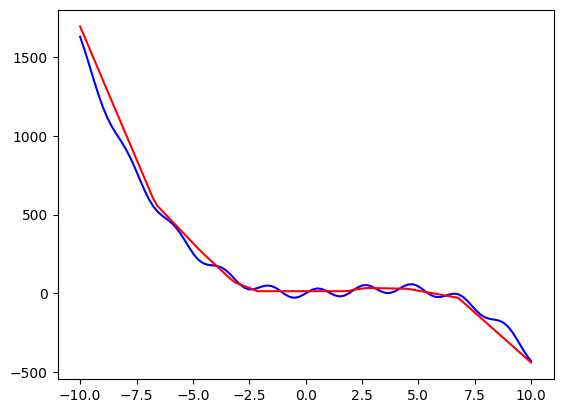

In [ ]:
X = np.linspace(-10, 10, 100).reshape(-1, 1)
y = fn(X)
keras_model = create_keras_model(server_state)
y_1 = keras_model.predict(X.reshape(-1, 1))


plt.plot(X, y, color="blue")
plt.plot(X, y_1, color="red")
plt.show()